In [1]:
import os
from itertools import product

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Download data

In [2]:
if not os.path.isdir('data'):
    os.mkdir('data')
    !kaggle competitions download -c playground-series-s5e11
    !unzip playground-series-s5e11.zip -d data
    !kaggle datasets download nabihazahid/loan-prediction-dataset-2025
    !unzip loan-prediction-dataset-2025.zip -d data
    !rm playground-series-s5e11.zip
    !rm loan-prediction-dataset-2025.zip

In [3]:
import sgpp
import sgml

import polars as pl
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns

/home/sun9sun9/python312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.metrics import roc_auc_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import shap

In [5]:
!head data/train.csv

id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.1,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.2,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.1,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.7,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0
5,44940.3,0.058,653,12159.92,12.24,Male,Single,Bachelor's,Employed,Other,D1,1.0
6,61574.16,0.042,696,16907.71,13.52,Other,Single,High School,Self-employed,Debt consolidation,C5,1.0
7,45953.31,0.1,654,10111.62,12.82,Female,Married,High School,Employed,Home,D1,1.0
8,30592.29,0.132,713,7522.36,9.48,Male,Married,Bachelor's,Employed,Education,C5,1.0


# Read data

In [6]:
p = make_pipeline(
    sgpp.PolarsProcessor(predefined_types={'id': pl.Int64}),
    sgpp.ExprProcessor({
        'loan_paid_back': pl.col('loan_paid_back').cast(pl.Int8)
    }),
    sgpp.PandasConverter(index_col = 'id')
)
df_train = p.fit_transform('data/train.csv')
df_test = p.transform('data/test.csv')
df_org = p.transform('data/loan_dataset_20000.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   annual_income         593994 non-null  float32 
 1   debt_to_income_ratio  593994 non-null  float32 
 2   credit_score          593994 non-null  int16   
 3   loan_amount           593994 non-null  float32 
 4   interest_rate         593994 non-null  float32 
 5   gender                593994 non-null  category
 6   marital_status        593994 non-null  category
 7   education_level       593994 non-null  category
 8   employment_status     593994 non-null  category
 9   loan_purpose          593994 non-null  category
 10  grade_subgrade        593994 non-null  category
 11  loan_paid_back        593994 non-null  int8    
dtypes: category(6), float32(4), int16(1), int8(1)
memory usage: 18.7 MB


In [8]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   20000 non-null  int64   
 1   gender                20000 non-null  category
 2   marital_status        20000 non-null  category
 3   education_level       20000 non-null  category
 4   annual_income         20000 non-null  float32 
 5   monthly_income        20000 non-null  float64 
 6   employment_status     20000 non-null  category
 7   debt_to_income_ratio  20000 non-null  float32 
 8   credit_score          20000 non-null  int16   
 9   loan_amount           20000 non-null  float32 
 10  loan_purpose          20000 non-null  category
 11  interest_rate         20000 non-null  float32 
 12  loan_term             20000 non-null  int64   
 13  installment           20000 non-null  float64 
 14  grade_subgrade        20000 non-null  category
 15  nu

In [9]:
pd.concat([
    df_train['loan_paid_back'].value_counts().rename('count'),
    df_train['loan_paid_back'].value_counts(normalize = True).rename('ratio')
], axis=1)

,count,ratio
loan_paid_back,,
1,474494,0.79882
0,119500,0.20118


In [10]:
X_num = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
X_cat = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
X_all = X_num + X_cat
y = 'loan_paid_back'

## 원본 데이터 활용성 체크

원본데이터의 분포를 train와 test를 구분하는 ML 모델을 만들어 체크합니다.

In [11]:
df_train_org = pd.concat([
    df_train[X_num + X_cat + [y]].assign(
        org = 0
    ),
    df_org.set_index(-(df_org.index + 1))[X_num + X_cat + [y]].assign(
        org = 1
    )
], axis=0)

In [12]:
from sklearn.model_selection import train_test_split

df_train_to, df_test_to = train_test_split(
    df_train_org, train_size = 0.8, random_state = 123
)

In [13]:
clf_lgb = lgb.LGBMClassifier(verbose = -1, random_state = 123)
clf_lgb.fit(df_train_to[X_num + X_cat + [y]], df_train_to['org'])

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(
    df_test_to['org'], clf_lgb.predict_proba(df_test_to[X_num + X_cat + [y]])[:, 1]
)

0.8277632054906675

In [15]:
clf_lgb.feature_importances_

array([562, 439, 397, 507, 350,  28,  58,  74,  98,  99, 327,  61],
      dtype=int32)

In [16]:
df_train_test = pd.concat([
    df_train[X_num + X_cat].assign(
        train = 1
    ),
    df_test[X_num + X_cat].assign(
        train = 0
    )
], axis=0)

In [17]:
df_train_to, df_test_to = train_test_split(
    df_train_test, train_size = 0.8, random_state = 123
)
clf_lgb = lgb.LGBMClassifier(verbose = -1, random_state = 123)
clf_lgb.fit(df_train_to[X_num + X_cat], df_train_to['train'])
from sklearn.metrics import roc_auc_score
roc_auc_score(
    df_test_to['train'], clf_lgb.predict_proba(df_test_to[X_num + X_cat])[:, 1]
)

0.5000394954216909

In [18]:
df_org_test = pd.concat([
    df_org[X_num + X_cat].assign(
        org = 1
    ),
    df_test[X_num + X_cat].assign(
        org = 0
    )
], axis=0)
df_train_to, df_test_to = train_test_split(
    df_org_test, train_size = 0.8, random_state = 123
)
clf_lgb = lgb.LGBMClassifier(verbose = -1, random_state = 123)
clf_lgb.fit(df_train_to[X_num + X_cat], df_train_to['org'])
from sklearn.metrics import roc_auc_score
roc_auc_score(
    df_test_to['org'], clf_lgb.predict_proba(df_test_to[X_num + X_cat])[:, 1]
)

0.82766676733178

train와 test를 분리하는 것은 AUC가 1이기 떄문에 어려운 작업이지만

org와 train, test는 0.82의 AUC를 얻을 수 있기 때문에 구분력이 있으므로 다른 점이 보입니다. 

원본 데이터를 넣는 것은 분포의 왜곡을 줄 수 있다고 생각이 듭니다.

## EDA

### Target Distribution

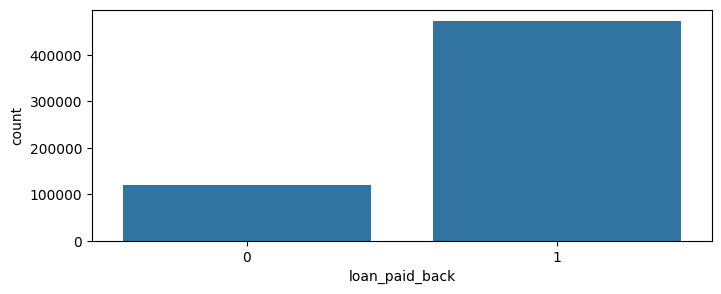

In [19]:
plt.figure(figsize = (8, 3))
sns.countplot(df_train, x = y)
plt.show()

### Numerical variables

In [20]:
df_train[X_num].describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.207031,0.120696,680.916009,15020.297852,12.356345
std,26711.943359,0.068573,55.424956,6926.530273,2.008959
min,6002.430176,0.011000,395.000000,500.089996,3.200000
25%,27934.400391,0.072000,646.000000,10279.620117,10.990000
50%,46557.679688,0.096000,682.000000,15000.219727,12.370000
75%,60981.320312,0.156000,719.000000,18858.580078,13.680000
max,393381.750000,0.627000,849.000000,48959.949219,20.990000


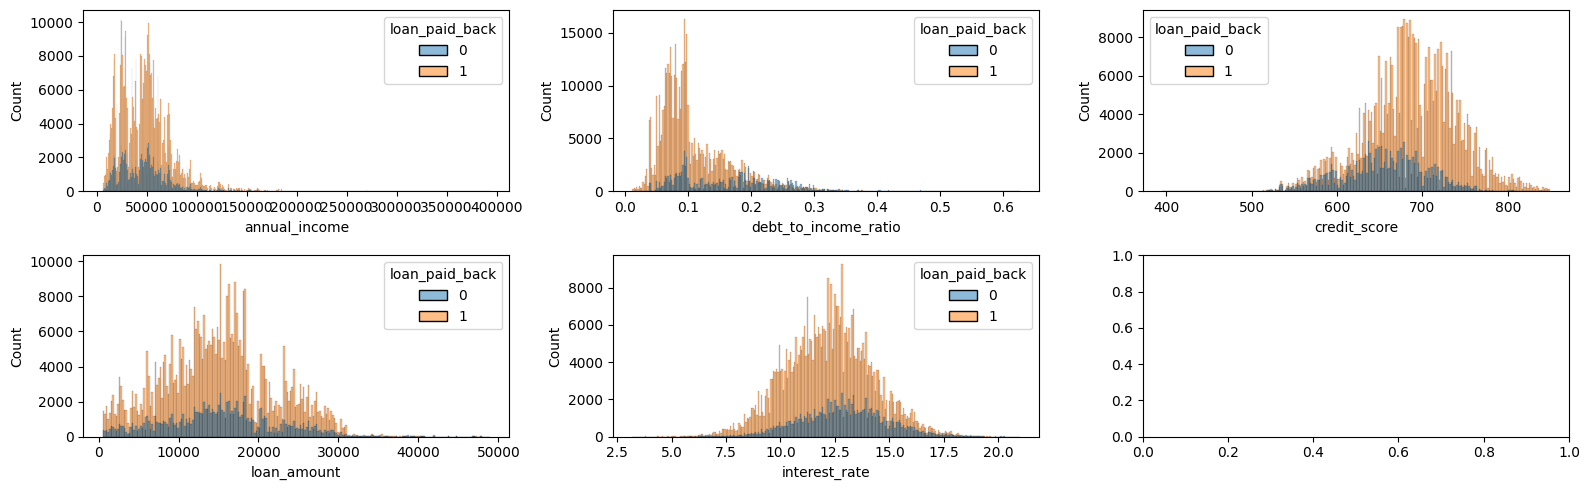

In [21]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5))
for i, ax in zip(X_num, axes.flatten()):
    sns.histplot(df_train, x = i, hue = y, ax = ax)
plt.tight_layout()
plt.show()

In [22]:
df_corr = df_train[X_num].corr()
df_corr

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
annual_income,1.000000,0.000553,0.001509,-0.003407,-0.002507
debt_to_income_ratio,0.000553,1.000000,-0.061617,-0.008236,0.030316
credit_score,0.001509,-0.061617,1.000000,-0.005761,-0.538335
loan_amount,-0.003407,-0.008236,-0.005761,1.000000,-0.001174
interest_rate,-0.002507,0.030316,-0.538335,-0.001174,1.000000


### Corrleation between numerical variables

In [23]:
df_corr.reset_index().melt(id_vars = 'index').pipe(
    lambda x: x.loc[x['index'] < x['variable']]
).sort_values('value', ascending = False)

,index,variable,value
21,debt_to_income_ratio,interest_rate,0.030316
10,annual_income,credit_score,0.001509
5,annual_income,debt_to_income_ratio,0.000553
19,interest_rate,loan_amount,-0.001174
20,annual_income,interest_rate,-0.002507
15,annual_income,loan_amount,-0.003407
17,credit_score,loan_amount,-0.005761
16,debt_to_income_ratio,loan_amount,-0.008236
7,credit_score,debt_to_income_ratio,-0.061617
22,credit_score,interest_rate,-0.538335


credit_score와 interest_rate가 상관도가 높다.

### ANOVA with target values

In [24]:
from scipy.stats import f_oneway

pd.Series({
    i: f_oneway(*df_train.groupby(y)[i].agg(list)).pvalue
    for i in X_num
}).sort_values().to_frame().T

,debt_to_income_ratio,credit_score,interest_rate,annual_income,loan_amount
0,0.0,0.0,0.0,0.000001,0.003737


In [25]:
roc_auc_score(
    df_train[y], -df_train['debt_to_income_ratio']
)

0.7152700521690291

In [26]:
roc_auc_score(
    df_train[y], df_train['credit_score']
)

0.6711532058294982

debt_to_income_ratio가 target과 가장 상관도가 높고 그다음에는 credit_score이다.

### Categorical variables

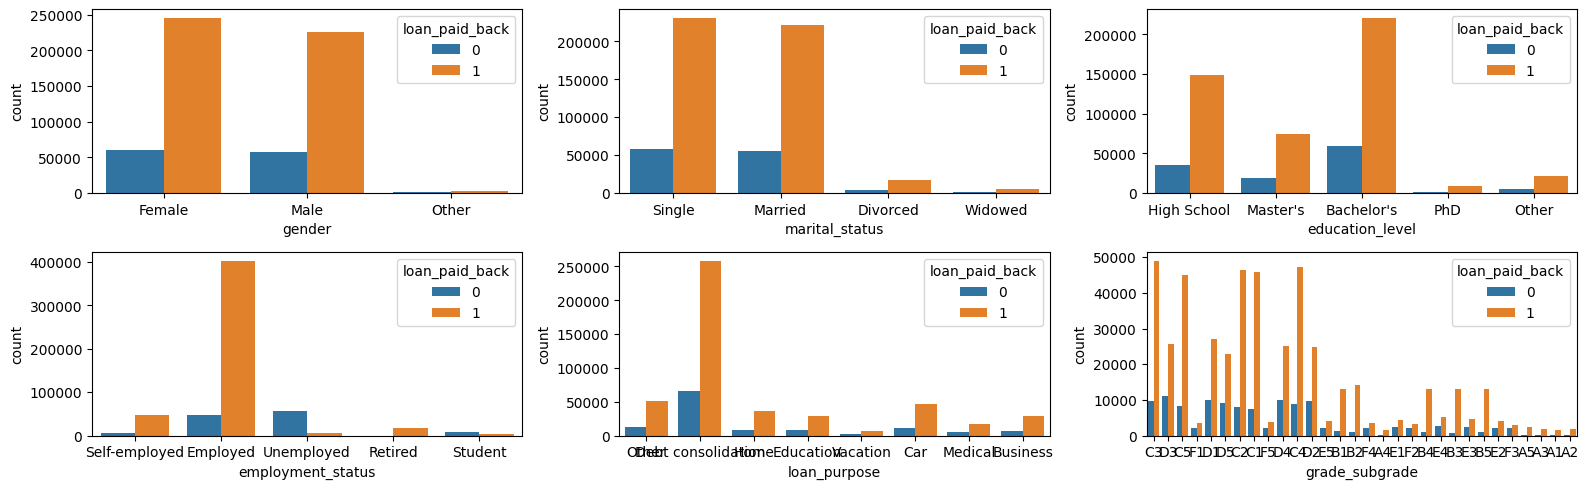

In [27]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5))
for i, ax in zip(X_cat, axes.flatten()):
    sns.countplot(df_train, x = i, hue = y, ax = ax)
plt.tight_layout()
plt.show()

#### chi2_contingency test with target

In [28]:
from scipy.stats import chi2_contingency

pd.Series({
    i: chi2_contingency(
        pd.crosstab(
            index = df_train[y], columns = df_train[i]
        )
    )[1]
    for i in X_cat
}).sort_values().to_frame().T

,employment_status,grade_subgrade,education_level,loan_purpose,gender,marital_status
0,0.0,0.0,1.055186e-81,1.725854e-80,7.495415e-08,0.248564


employment_status와 targe과 연관성이 높고, 그 다음에는 grade_subgrade가 높다,

In [29]:
from scipy.spatial.distance import pdist, squareform
pd.DataFrame(
    squareform(
        pdist(
            df_train[X_cat].T, 
            metric = lambda u, v: chi2_contingency(
                pd.crosstab(index = u, columns = v)
            )[1]
        )
    ), index = X_cat, columns = X_cat
).reset_index().melt(id_vars = 'index').pipe(
    lambda x: x.loc[x['index'] < x['variable']]
).sort_values('value', ascending = True)

,index,variable,value
33,employment_status,grade_subgrade,0.000000e+00
27,employment_status,loan_purpose,3.495173e-95
20,education_level,employment_status,1.508930e-70
32,education_level,grade_subgrade,1.823507e-54
26,education_level,loan_purpose,1.174815e-50
11,grade_subgrade,marital_status,8.373960e-39
10,loan_purpose,marital_status,2.127016e-33
8,education_level,marital_status,2.500353e-22
29,grade_subgrade,loan_purpose,5.555442e-21
9,employment_status,marital_status,1.392018e-12


employment_status와 grade_subgrade와 연관성이 높다.

In [30]:
df_anova = pd.DataFrame([
    (i, j, f_oneway(*df_train.groupby(j)[i].agg(list)).pvalue)
    for i, j in product(X_num, X_cat)
], columns = ['cat', 'cont', 'pvalue'])
df_anova.sort_values('pvalue')

,cat,cont,pvalue
11,debt_to_income_ratio,grade_subgrade,0.000000e+00
15,credit_score,employment_status,0.000000e+00
9,debt_to_income_ratio,employment_status,0.000000e+00
17,credit_score,grade_subgrade,0.000000e+00
29,interest_rate,grade_subgrade,0.000000e+00
27,interest_rate,employment_status,1.232892e-307
10,debt_to_income_ratio,loan_purpose,1.163941e-29
23,loan_amount,grade_subgrade,2.851169e-19
16,credit_score,loan_purpose,1.132175e-16
13,credit_score,marital_status,1.696289e-14


## Analysis with ML

In [31]:
df_train_ho, df_test_ho = train_test_split(df_train, train_size = 0.8, random_state = 123)

In [32]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_cat),
    ('pt', 'passthrough', X_num)
])

clf_dt = make_pipeline(
    ct, DecisionTreeClassifier(max_depth = 8)
)
clf_dt.fit(df_train_ho[X_all], df_train_ho[y])

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('ohe', ...), ('pt', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [33]:
(
    roc_auc_score(
        df_train_ho[y], clf_dt.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_dt.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9126415043324629, 0.9127372055638713)

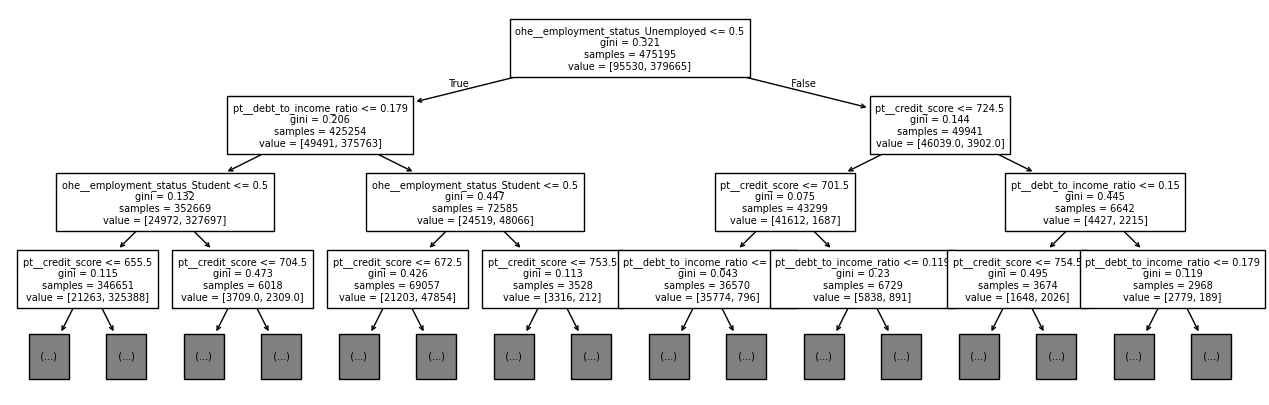

In [34]:
from sklearn.tree import plot_tree
plt.figure(figsize = (16, 5))
plot_tree(clf_dt[-1], feature_names = clf_dt[0].get_feature_names_out(), max_depth = 3, fontsize = 7)
plt.show()

In [35]:
pd.DataFrame(
    clf_dt[-1].feature_importances_, index = clf_dt[0].get_feature_names_out(), columns = ['importance']
).reset_index().pipe(
    lambda x: x['index'].str.split('__', expand=True).join(x['importance'])
).groupby(1)['importance'].sum().sort_values(ascending = False).iloc[:10]

1
employment_status_Unemployed    0.705977
debt_to_income_ratio            0.138984
employment_status_Student       0.077089
credit_score                    0.070399
employment_status_Retired       0.004983
annual_income                   0.000873
loan_amount                     0.000711
interest_rate                   0.000360
grade_subgrade_B3               0.000103
grade_subgrade_B1               0.000083
Name: importance, dtype: float64

In [36]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_cat),
    ('pt', StandardScaler(), X_num)
])

clf_lr = make_pipeline(
    ct, LogisticRegression(fit_intercept = False)
)
clf_lr.fit(df_train_ho[X_all], df_train_ho[y])

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('logisticregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('ohe', ...), ('pt', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differen

In [37]:
roc_auc_score(
    df_test_ho[y], clf_lr.predict_proba(df_test_ho[X_all])[:, 1]
)

0.9117058823045481

In [38]:
pd.DataFrame(
    clf_lr[-1].coef_[0], index = clf_lr[0].get_feature_names_out(), columns = ['coef']
).reset_index().pipe(
    lambda x: x['index'].str.split('__', expand=True).join(x['coef'].abs())
).groupby(1)['coef'].sum().sort_values(ascending = False).iloc[:10]

1
employment_status_Retired          5.016624
employment_status_Unemployed       3.807674
employment_status_Student          2.118240
employment_status_Self-employed    1.289149
employment_status_Employed         1.288981
debt_to_income_ratio               0.861296
credit_score                       0.850537
gender_Female                      0.601291
grade_subgrade_B3                  0.562236
gender_Male                        0.550786
Name: coef, dtype: float64

In [39]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['employment_status']),
    ('std', StandardScaler(), ['debt_to_income_ratio', 'credit_score'])
])

clf_lr = make_pipeline(
    ct, LogisticRegression()
)
clf_lr.fit(df_train_ho[X_all], df_train_ho[y])
(
    roc_auc_score(
        df_train_ho[y], clf_lr.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lr.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9097091706992226, 0.9108139292053674)

In [40]:
pd.Series(clf_lr[-1].coef_[0], index = clf_lr[0].get_feature_names_out())

ohe__employment_status_Retired          3.696934
ohe__employment_status_Self-employed    0.003552
ohe__employment_status_Student         -3.372334
ohe__employment_status_Unemployed      -4.990399
std__debt_to_income_ratio              -0.859299
std__credit_score                       0.799960
dtype: float64

In [41]:
from scipy.stats import zscore
roc_auc_score(
    df_test_ho[y], zscore(df_test_ho['credit_score']) - zscore(df_test_ho['debt_to_income_ratio'])
)

0.7724465104751075

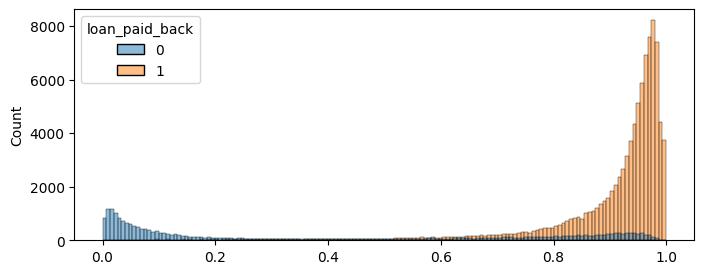

In [42]:
plt.figure(figsize = (8, 3))
sns.histplot(
    x = clf_lr.predict_proba(df_test_ho[X_all])[:, 1], hue = df_test_ho[y]
)
plt.show()

**employment_status** 가 가장 중요한 속성으로 보입니다.

In [43]:
s_ratio = df_train.groupby('employment_status').apply(lambda x: (x[y] == 1).mean(), include_groups=False)
s_ratio

employment_status
Self-employed    0.898457
Employed         0.894145
Unemployed       0.077619
Retired          0.997204
Student          0.263515
dtype: float64

In [44]:
df_train['employment_status'].value_counts()

employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64

In [45]:
(
    roc_auc_score(df_train_ho[y], df_train_ho['employment_status'].map(s_ratio)),
    roc_auc_score(df_test_ho[y], df_test_ho['employment_status'].map(s_ratio))
)

(0.7790427290101011, 0.7793472885935477)

In [46]:
from sklearn.preprocessing import PolynomialFeatures
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_cat),
    ('std_p2', make_pipeline(StandardScaler(), PolynomialFeatures()), X_num)
])

clf_lr = make_pipeline(
    ct, LogisticRegression(fit_intercept = False)
)
clf_lr.fit(df_train_ho[X_all], df_train_ho[y])

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('logisticregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('ohe', ...), ('std_p2', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [47]:
(
    roc_auc_score(
        df_train_ho[y], clf_lr.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lr.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9113448896571068, 0.9124092848716518)

In [48]:
from sklearn.preprocessing import PolynomialFeatures
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_cat),
    ('std',StandardScaler(), X_num)
])

clf_lr = make_pipeline(
    ct, PolynomialFeatures(), LogisticRegression(fit_intercept = False)
)
clf_lr.fit(df_train_ho[X_all], df_train_ho[y])

/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('polynomialfeatures', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('ohe', ...), ('std', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the di

In [49]:
(
    roc_auc_score(
        df_train_ho[y], clf_lr.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lr.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.912165521431898, 0.9122342571326146)

In [50]:
pd.Series(clf_lr[-1].coef_[0], clf_lr[1].get_feature_names_out(clf_lr[0].get_feature_names_out())).abs().sort_values(ascending = False).iloc[:50]

ohe__employment_status_Retired^2                                          1.403322
ohe__employment_status_Retired                                            1.403322
ohe__employment_status_Unemployed^2                                       1.352019
ohe__employment_status_Unemployed                                         1.352019
ohe__gender_Female ohe__employment_status_Retired                         0.710407
ohe__marital_status_Single ohe__employment_status_Retired                 0.708944
ohe__gender_Male ohe__employment_status_Retired                           0.675276
ohe__gender_Female ohe__employment_status_Unemployed                      0.659074
ohe__employment_status_Retired ohe__loan_purpose_Debt consolidation       0.641404
ohe__education_level_Bachelor's ohe__employment_status_Retired            0.630392
ohe__employment_status_Student                                            0.624700
ohe__employment_status_Student^2                                          0.624700
ohe_

In [51]:
from sklearn.preprocessing import FunctionTransformer

In [52]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['employment_status']),
    ('std', make_pipeline(StandardScaler(), PolynomialFeatures()), ['debt_to_income_ratio', 'credit_score']),
    ('rec_std', make_pipeline(FunctionTransformer(lambda x: 1/x), StandardScaler()), ['debt_to_income_ratio', 'credit_score'])
])

clf_lr = make_pipeline(
    ct, LogisticRegression()
)
clf_lr.fit(df_train_ho[X_all], df_train_ho[y])
(
    roc_auc_score(
        df_train_ho[y], clf_lr.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lr.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9106357008144893, 0.9116511175883668)

In [53]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['employment_status']),
    ('std', make_pipeline(StandardScaler(), PolynomialFeatures()), ['debt_to_income_ratio', 'credit_score']),
    ('log_std', make_pipeline(FunctionTransformer(lambda x: np.log(x)), StandardScaler()), ['debt_to_income_ratio', 'credit_score'])
])

clf_lr = make_pipeline(
    ct, LogisticRegression()
)
clf_lr.fit(df_train_ho[X_all], df_train_ho[y])
(
    roc_auc_score(
        df_train_ho[y], clf_lr.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lr.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9107034607353257, 0.911723346935887)

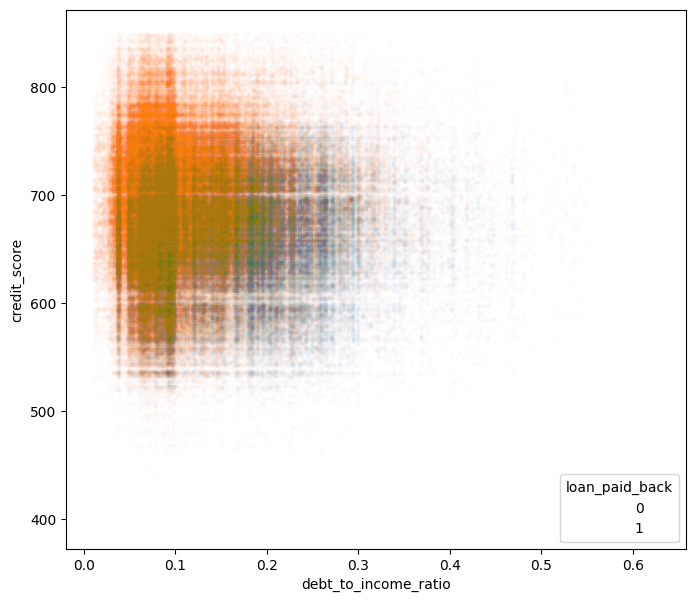

In [54]:
plt.figure(figsize = (8, 7))
sns.scatterplot(
    df_train, x = 'debt_to_income_ratio', y = 'credit_score', hue = y, s = 10, alpha = 0.01
)
plt.show()

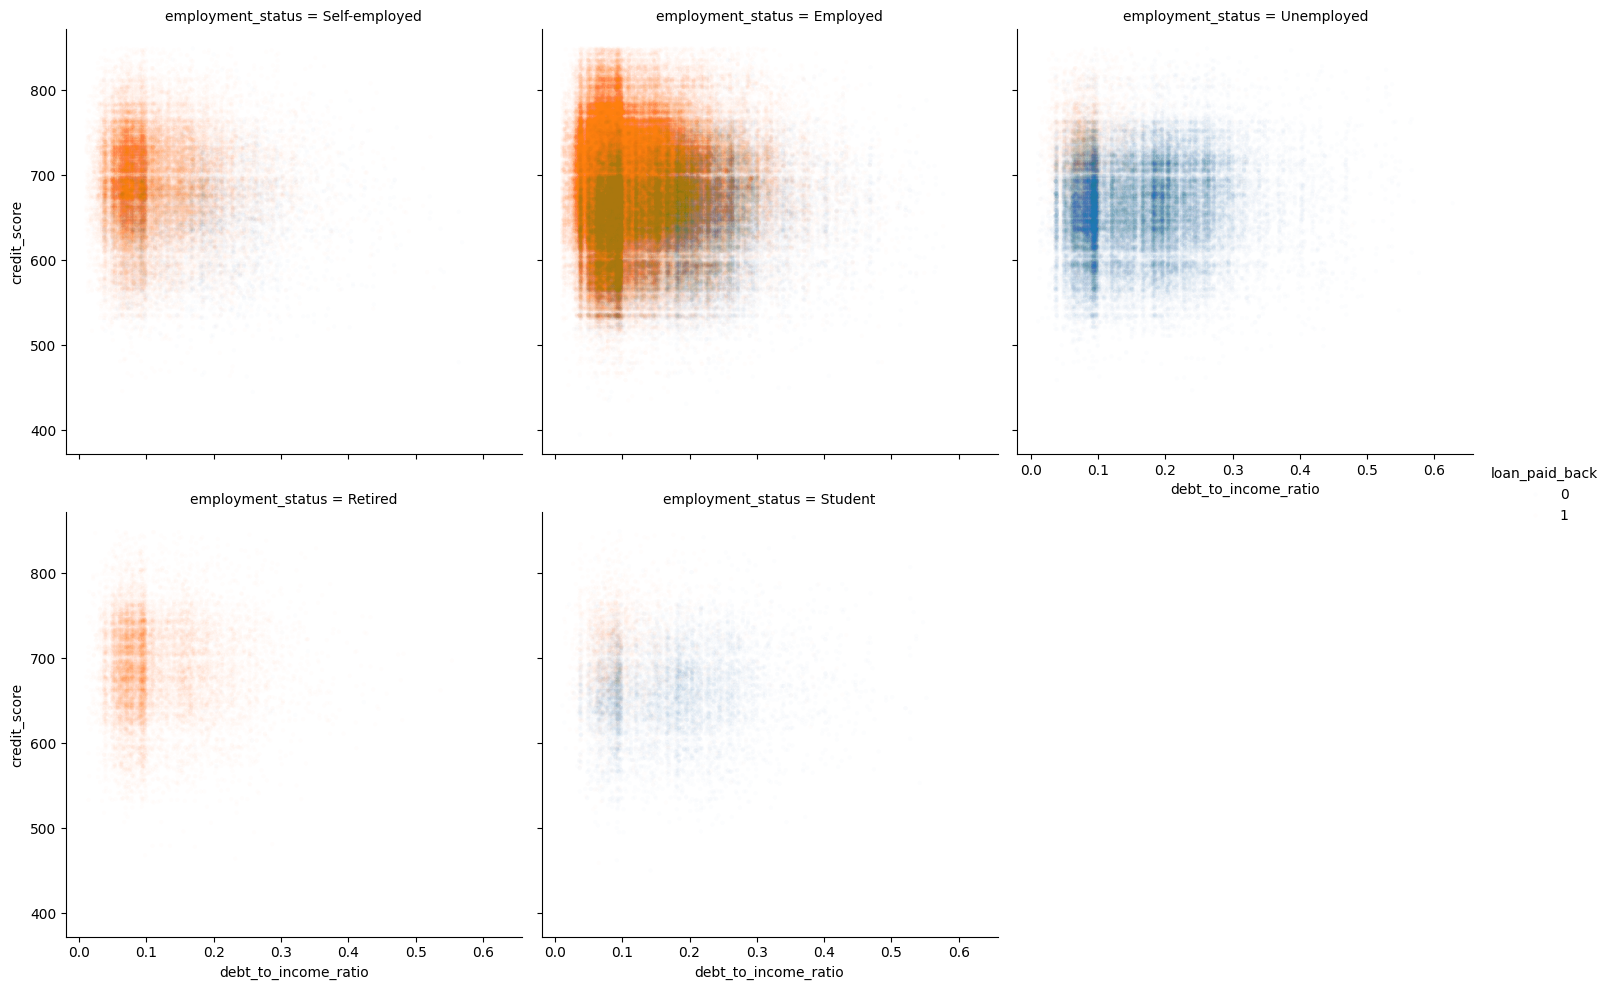

In [55]:
sns.relplot(
    df_train, x = 'debt_to_income_ratio', y = 'credit_score', hue = y, col='employment_status', col_wrap = 3, s = 10, alpha = 0.01
)
plt.show()

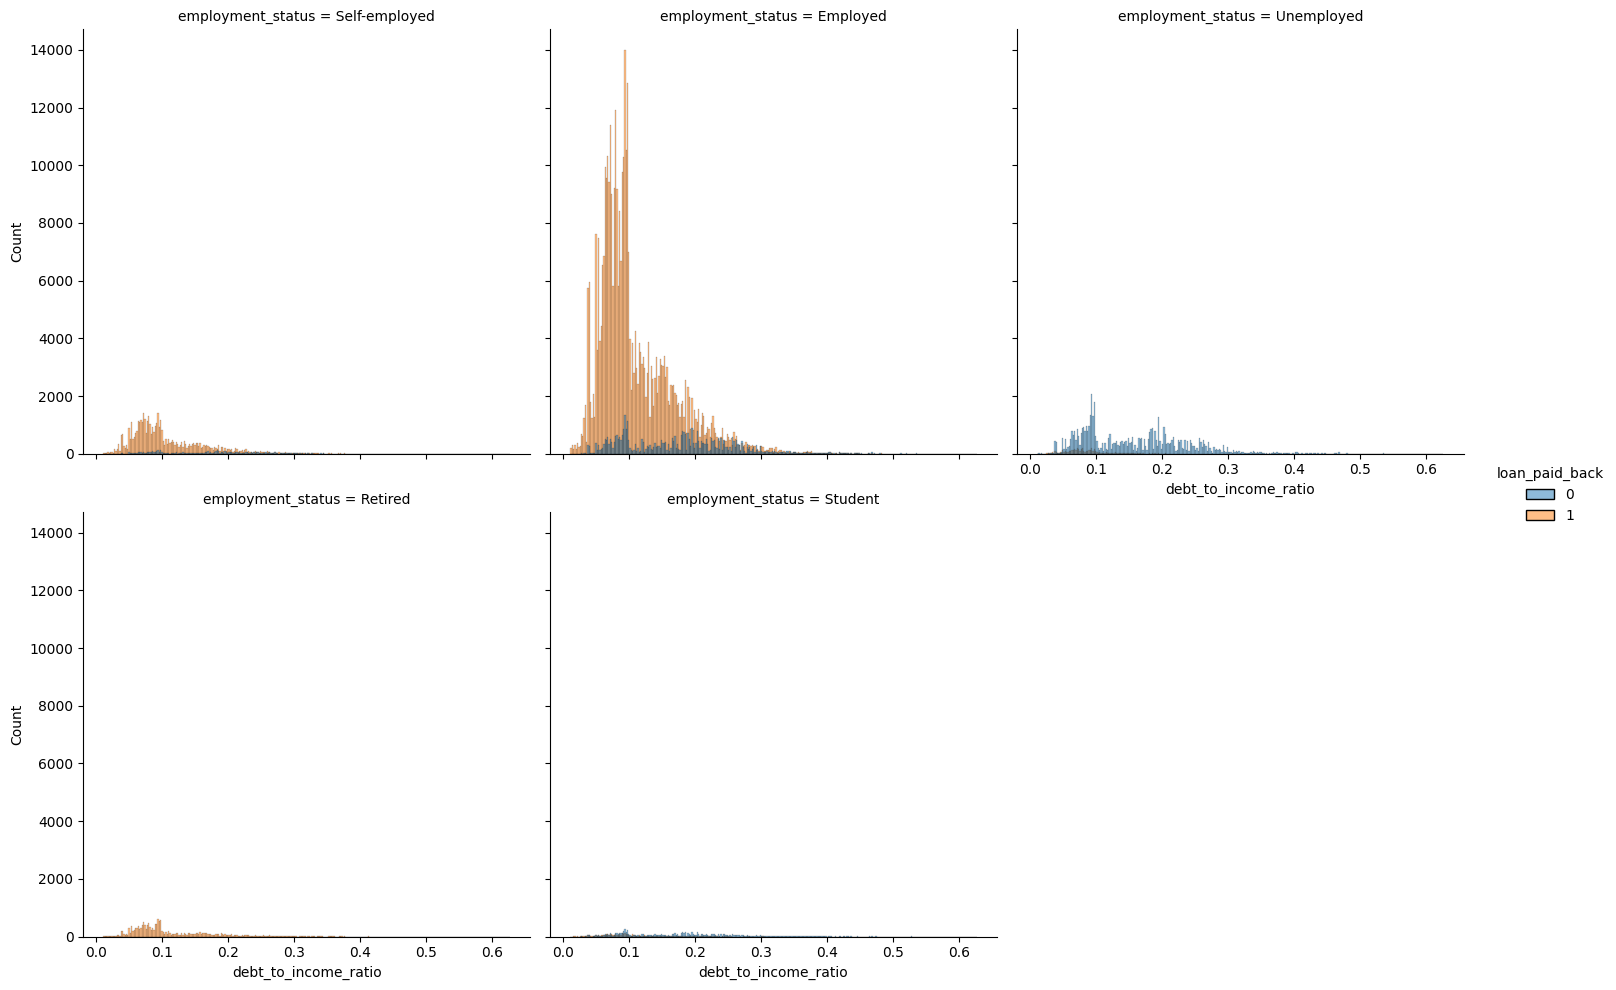

In [56]:
sns.displot(
    df_train, x = 'debt_to_income_ratio', hue = y, col='employment_status', col_wrap = 3,
)
plt.show()

<Figure size 800x700 with 0 Axes>

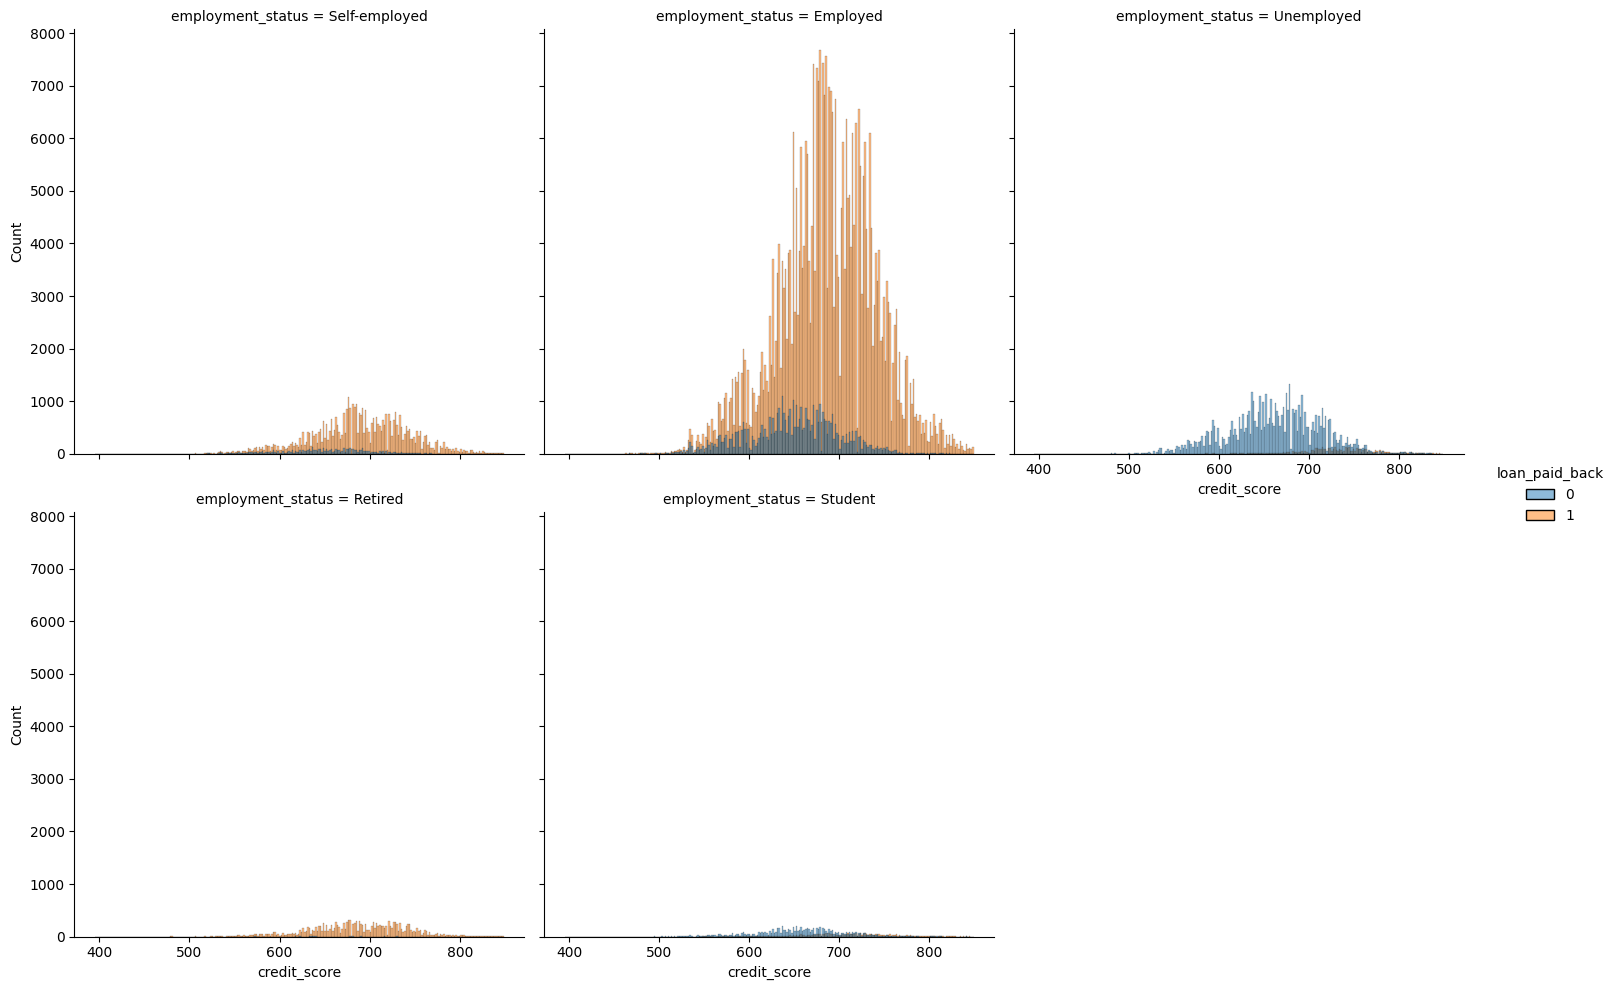

In [57]:
plt.figure(figsize = (8, 7))
sns.displot(
    df_train, x = 'credit_score', hue = y, col='employment_status', col_wrap = 3,
)
plt.show()

In [58]:
df_train[X_num].apply(lambda x: x.nunique()).rename('nunique').to_frame().T

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
nunique,119666,526,399,111570,1454


In [59]:
df_train[['debt_to_income_ratio', 'credit_score', 'employment_status']].value_counts()

debt_to_income_ratio  credit_score  employment_status
0.093                 672           Employed             110
0.090                 708           Employed             109
0.093                 708           Employed             106
0.097                 672           Employed             105
0.093                 669           Employed             101
                                                        ... 
0.011                 607           Employed               1
                      601           Employed               1
                      592           Employed               1
                      588           Employed               1
                      584           Employed               1
Name: count, Length: 146932, dtype: int64

In [60]:
df_train[['debt_to_income_ratio', 'credit_score', 'employment_status']].value_counts().value_counts().iloc[:10]

count
1     70886
2     25319
3     13078
4      7960
5      5345
6      3995
7      2906
8      2326
9      1826
10     1503
Name: count, dtype: int64

In [61]:
df_train[['debt_to_income_ratio', 'credit_score']].value_counts().value_counts().iloc[:10]

count
1     21800
2     10685
3      6986
4      4941
5      3863
6      3166
7      2655
8      2158
9      1831
10     1618
Name: count, dtype: int64

In [62]:
df_train.groupby(['debt_to_income_ratio', 'credit_score', 'employment_status']).filter(lambda x: len(x) >= 30).groupby(
    ['debt_to_income_ratio', 'credit_score', 'employment_status'], observed = True
)[y].agg(['mean', 'count']).sort_values('mean')

mean  count
debt_to_income_ratio credit_score employment_status                 
0.094                637          Employed           0.676471     34
0.097                637          Employed           0.687500     32
                     644          Employed           0.702703     37
0.093                646          Employed           0.704918     61
0.094                654          Employed           0.710526     38
...                                                       ...    ...
0.066                734          Employed           1.000000     46
                     736          Employed           1.000000     35
                     739          Employed           1.000000     36
0.067                626          Employed           1.000000     50
0.153                708          Employed           1.000000     31

[3067 rows x 2 columns]

In [63]:
s_ratio = df_train.groupby('grade_subgrade').apply(lambda x: (x[y] == 1).mean(), include_groups=False)
pd.concat([
    s_ratio.rename('ratio'), 
    df_train['grade_subgrade'].value_counts().rename('cnt')
], axis=1).sort_values('ratio')

,ratio,cnt
grade_subgrade,,
F3,0.604093,5082
F2,0.617721,5203
F1,0.624503,5534
F4,0.637037,5535
F5,0.639314,5947
E3,0.641837,7075
E4,0.649577,8036
E1,0.652010,6891
E2,0.662743,6372


In [64]:
(
    roc_auc_score(df_train_ho[y], df_train_ho['grade_subgrade'].map(s_ratio)),
    roc_auc_score(df_test_ho[y], df_test_ho['grade_subgrade'].map(s_ratio))
)

(0.6570200012104145, 0.658087256928532)

In [65]:
import xgboost as xgb
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_cat),
    ('pt', StandardScaler(), X_num)
])
clf_xgb = xgb.XGBClassifier(
    tree_method = 'hist', device = 'cuda'
)
clf_xgb.fit(ct.fit_transform(df_train_ho[X_all]), df_train_ho[y])

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",'cuda'
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

In [66]:
(
    roc_auc_score(
        df_train_ho[y], clf_xgb.predict_proba(ct.transform(df_train_ho[X_all]))[:,  1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_xgb.predict_proba(ct.transform(df_test_ho[X_all]))[:,  1]
    )
)

/home/sun9sun9/python312/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [15:13:35] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


(0.930124882306254, 0.9213728388503077)

In [67]:
pd.Series(clf_xgb.feature_importances_, ct.get_feature_names_out()).sort_values(ascending = False).iloc[:10]

ohe__employment_status_Unemployed    0.837299
ohe__employment_status_Student       0.081424
ohe__employment_status_Retired       0.020174
pt__debt_to_income_ratio             0.012442
pt__credit_score                     0.008878
ohe__grade_subgrade_F3               0.001179
ohe__grade_subgrade_B3               0.001166
ohe__grade_subgrade_C1               0.001034
pt__loan_amount                      0.000995
ohe__grade_subgrade_D3               0.000916
dtype: float32

In [68]:
explainer = shap.TreeExplainer(clf_xgb)

In [69]:
shap_interaction = explainer.shap_interaction_values(ct.transform(df_test_ho[X_all]))

In [70]:
df_intr = pd.DataFrame(
    np.abs(shap_interaction).mean(axis = 0), index = ct.get_feature_names_out(), columns = ct.get_feature_names_out()
)

In [71]:
df_intr.stack().rename('value').reset_index().pipe(
    lambda x: x.loc[x['level_0'] < x['level_1']]
).sort_values('value', ascending = False).iloc[:20]

,level_0,level_1,value
3476,pt__credit_score,pt__debt_to_income_ratio,0.084199
1017,ohe__employment_status_Unemployed,pt__credit_score,0.053813
1016,ohe__employment_status_Unemployed,pt__debt_to_income_ratio,0.028397
3356,pt__annual_income,pt__debt_to_income_ratio,0.023567
3418,pt__debt_to_income_ratio,pt__loan_amount,0.019727
3479,pt__credit_score,pt__interest_rate,0.019019
3419,pt__debt_to_income_ratio,pt__interest_rate,0.017707
3357,pt__annual_income,pt__credit_score,0.016703
916,ohe__employment_status_Student,ohe__employment_status_Unemployed,0.016214
3358,pt__annual_income,pt__loan_amount,0.014375


In [72]:
clf_lgb = lgb.LGBMClassifier(verbose = -1, categorical_features = X_cat)
clf_lgb.fit(df_train_ho[X_all], df_train_ho[y])

/home/sun9sun9/python312/lib/python3.12/site-packages/lightgbm/basic.py:2139: UserWarning: categorical_features in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [73]:
(
    roc_auc_score(
        df_train_ho[y], clf_lgb.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_lgb.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9219875314746923, 0.9206961774326651)

In [74]:
pd.Series(clf_lgb.feature_importances_, X_all).sort_values(ascending = False)

debt_to_income_ratio    1159
credit_score             504
grade_subgrade           351
employment_status        255
loan_amount              247
annual_income            226
interest_rate            149
loan_purpose              50
education_level           33
marital_status            14
gender                    12
dtype: int32

In [75]:
clf_cb = cb.CatBoostClassifier(
    cat_features = X_cat, verbose = False, n_estimators = 300, task_type = 'CPU', border_count = 254
)
clf_cb.fit(df_train_ho[X_all], df_train_ho[y])

In [76]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[X_all])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[X_all])[:, 1]
    )
)

(0.9278910758414047, 0.9235481469349964)

#### grade_subgrade 서수화

In [77]:
c_map = {
    c: i
    for i, c in enumerate(np.sort(df_train['grade_subgrade'].unique()))
}
df_train['grade_subgrade_no'] = df_train['grade_subgrade'].map(c_map).astype(np.int16)
df_test['grade_subgrade_no'] = df_test['grade_subgrade'].map(c_map).astype(np.int16)

In [78]:
with open('grade_subgrade.pkl', 'wb') as f:
    pkl.dump(c_map, f)

In [79]:
df_train_ho, df_test_ho = train_test_split(df_train, train_size = 0.8, random_state = 123)

In [80]:
X_cb = [i for i in X_all if i != 'grade_subgrade']  + ['grade_subgrade_no']

In [81]:
clf_cb = cb.CatBoostClassifier(
    cat_features = [i for i in X_cat if i != 'grade_subgrade'], verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[X_cb], df_train_ho[y])

In [82]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[X_cb])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[X_cb])[:, 1]
    )
)

(0.9287651811541193, 0.9236646634517192)

grade_subgrade_no로 바꾼 것에 미약한 효과가 보임

In [83]:
pd.Series(
    clf_cb.get_feature_importance(), index = X_cb
).sort_values(ascending = False)

employment_status       36.609305
debt_to_income_ratio    29.236620
credit_score            20.338978
grade_subgrade_no        4.089653
loan_amount              3.055720
annual_income            2.480805
interest_rate            2.306708
education_level          0.590274
loan_purpose             0.548052
marital_status           0.377326
gender                   0.366560
dtype: float64

In [84]:
pd.DataFrame(
    clf_cb.get_feature_importance(type = 'Interaction'), columns = ['v1', 'v2', 'importance']
).assign(
    v1 = lambda x: x['v1'].astype('int').apply(lambda x: X_cb[x]),
    v2 = lambda x: x['v2'].astype('int').apply(lambda x: X_cb[x])
).iloc[:10]

,v1,v2,importance
0,debt_to_income_ratio,credit_score,9.110104
1,debt_to_income_ratio,loan_amount,7.435589
2,debt_to_income_ratio,interest_rate,6.484475
3,annual_income,debt_to_income_ratio,6.462647
4,debt_to_income_ratio,employment_status,5.789290
5,credit_score,interest_rate,4.524409
6,credit_score,loan_amount,4.398130
7,annual_income,loan_amount,3.647919
8,loan_amount,interest_rate,3.229306
9,debt_to_income_ratio,grade_subgrade_no,3.189092


#### debt_to_income_ratio에 annual_income을 곱해 debt을 구하기

In [85]:
df_train['debt'] = df_train['debt_to_income_ratio'] * df_train['annual_income']

In [86]:
df_train_ho, df_test_ho = train_test_split(df_train, train_size = 0.8, random_state = 123)

In [87]:
clf_cb = cb.CatBoostClassifier(
    cat_features = [i for i in X_cat if i != 'grade_subgrade'], verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[[i for i in X_all if i != 'grade_subgrade'] + ['grade_subgrade_no', 'debt']], df_train_ho[y])

In [88]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[[i for i in X_all if i != 'grade_subgrade']  + ['grade_subgrade_no', 'debt']])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[[i for i in X_all if i != 'grade_subgrade']  + ['grade_subgrade_no', 'debt']])[:, 1]
    )
)

(0.9284761495534578, 0.9234925313800575)

#### employment_status 서수화

In [89]:
s_ratio = df_train.groupby('employment_status').apply(lambda x: (x[y] == 1).mean(), include_groups=False)
s_ratio

employment_status
Self-employed    0.898457
Employed         0.894145
Unemployed       0.077619
Retired          0.997204
Student          0.263515
dtype: float64

In [90]:
employment_status_map = {'Self-employed': 2, 'Employed': 2, 'Unemployed': 0, 'Student': 1, 'Retired': 3}
df_train_ho['employment_status_no'] = df_train_ho['employment_status'].map(employment_status_map)
df_test_ho['employment_status_no'] = df_test_ho['employment_status'].map(employment_status_map)

In [91]:
X_cb = [i for i in X_all if i not in ['grade_subgrade', 'employment_status']] + ['grade_subgrade_no', 'employment_status_no']
clf_cb = cb.CatBoostClassifier(
    cat_features = [i for i in X_cat if i not in ['grade_subgrade', 'employment_status']], verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[X_cb], df_train_ho[y])

In [92]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[X_cb])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[X_cb])[:, 1]
    )
)

(0.9287216732904395, 0.9238292294815207)

In [93]:
employment_status_map = {'Self-employed': 2, 'Employed': 3, 'Unemployed': 0, 'Student': 1, 'Retired': 4}
df_train_ho['employment_status_no'] = df_train_ho['employment_status'].map(employment_status_map).astype('int')
df_test_ho['employment_status_no'] = df_test_ho['employment_status'].map(employment_status_map).astype('int')

In [94]:
X_cb = [i for i in X_all if i not in ['grade_subgrade', 'employment_status']] + ['grade_subgrade_no', 'employment_status_no']
clf_cb = cb.CatBoostClassifier(
    cat_features = [i for i in X_cat if i not in ['grade_subgrade', 'employment_status']], verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[X_cb], df_train_ho[y])

In [95]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[X_cb])[:, 1]
    ),
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[X_cb])[:, 1]
    )
)

(0.9287744595271736, 0.9236061284727899)

employment_status 서수화 효과성 없음

<Axes: xlabel='loan_paid_back', ylabel='Count'>

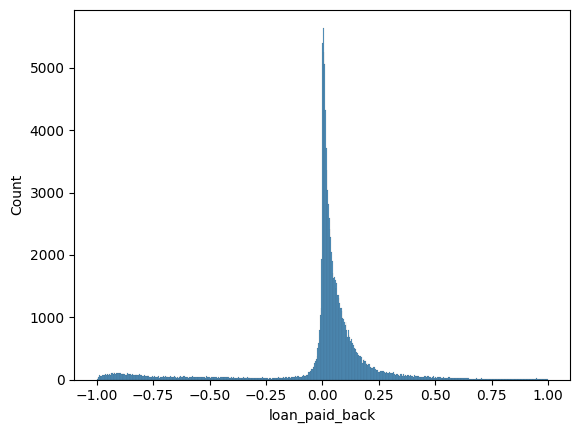

In [96]:
s_err = (df_test_ho[y] - clf_cb.predict_proba(df_test_ho[X_cb])[:, 1])
sns.histplot(
    s_err
)

#### False Positive

In [97]:
(s_err < -0.75).sum()

np.int64(5744)

In [98]:
pd.concat([
    df_test_ho.loc[s_err < -0.75, 'employment_status'].value_counts(normalize = True).rename('ratio'),
    df_test_ho.loc[s_err < -0.75, 'employment_status'].value_counts().rename('count')
], axis=1)

,ratio,count
employment_status,,
Employed,0.882138,5067
Self-employed,0.102019,586
Student,0.008357,48
Unemployed,0.006093,35
Retired,0.001393,8


In [99]:
df_test_ho['employment_status'].value_counts(normalize = True)

employment_status
Employed         0.758777
Unemployed       0.105590
Self-employed    0.087997
Retired          0.027559
Student          0.020076
Name: proportion, dtype: float64

<Figure size 800x700 with 0 Axes>

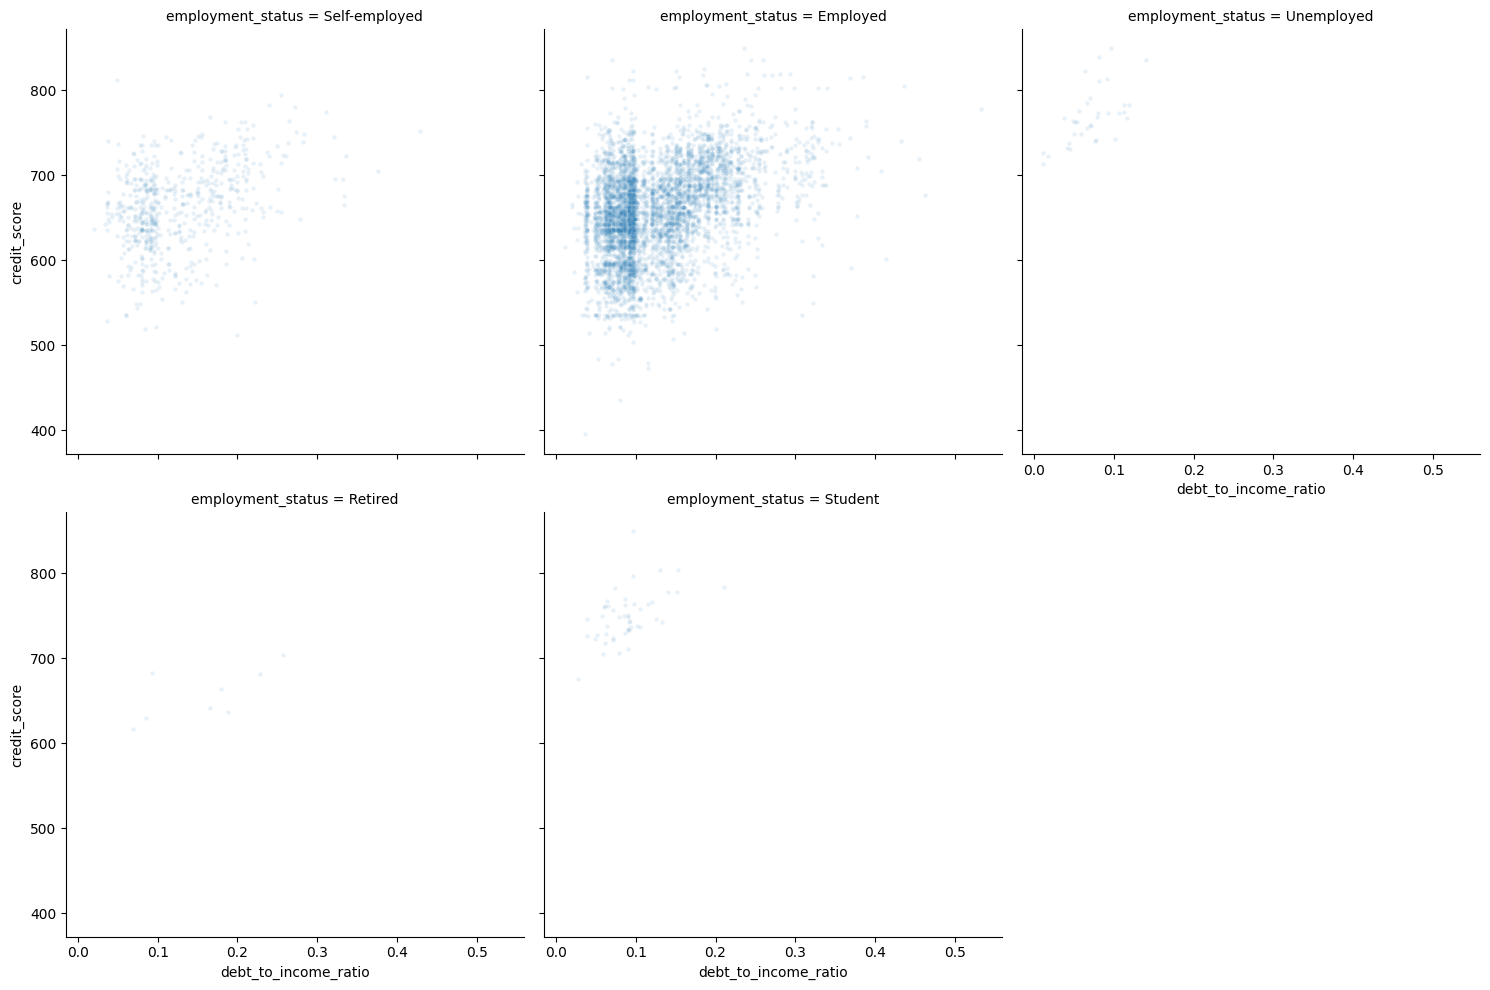

In [100]:
plt.figure(figsize = (8, 7))
sns.relplot(
    df_test_ho.loc[s_err < -0.75], x = 'debt_to_income_ratio', y = 'credit_score', col='employment_status', col_wrap = 3, s = 10, alpha = 0.1
)
plt.show()

In [101]:
df_tp = pd.concat([
    df_test_ho[(df_test_ho[y] == 1) & (s_err < 0.25)].assign(
        is_tp = 1
    ),
    df_test_ho[s_err < -0.75].assign(
        is_tp = 0
    )
], axis = 0)

In [102]:
df_tp_train, df_tp_test = train_test_split(df_tp, train_size = 0.8, random_state = 123, stratify = df_tp['is_tp'])

In [103]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_cat),
    ('pt', 'passthrough', X_num)
])

clf_dt = make_pipeline(
    ct, DecisionTreeClassifier(max_depth = 8)
)
clf_dt.fit(df_tp_train[X_all], df_tp_train['is_tp'])

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('ohe', ...), ('pt', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diff

In [104]:
(
    roc_auc_score(
        df_tp_train['is_tp'], clf_dt.predict_proba(df_tp_train[X_all])[:, 1]
    ),
    roc_auc_score(
        df_tp_test['is_tp'], clf_dt.predict_proba(df_tp_test[X_all])[:, 1]
    )
)

(0.7646795835482689, 0.7330463899830394)

In [105]:
pd.Series(
    clf_dt[1].feature_importances_, clf_dt[0].get_feature_names_out()
).sort_values(ascending = False).iloc[:10]

pt__credit_score                     0.348667
pt__debt_to_income_ratio             0.337424
pt__annual_income                    0.065063
pt__loan_amount                      0.057498
pt__interest_rate                    0.055882
ohe__employment_status_Retired       0.045828
ohe__employment_status_Student       0.013374
ohe__employment_status_Unemployed    0.012207
ohe__education_level_High School     0.009058
ohe__grade_subgrade_D2               0.008643
dtype: float64

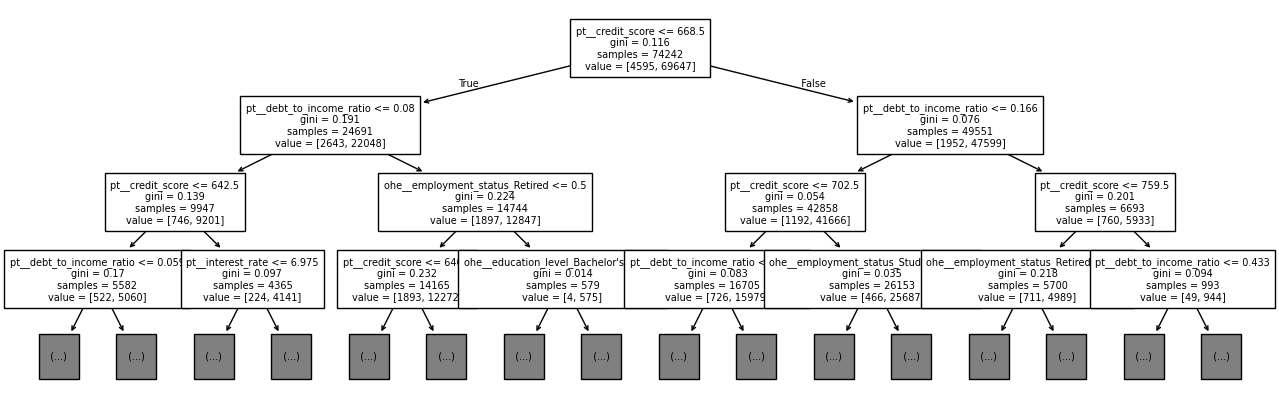

In [106]:
from sklearn.tree import plot_tree
plt.figure(figsize = (16, 5))
plot_tree(clf_dt[-1], feature_names = clf_dt[0].get_feature_names_out(), max_depth = 3, fontsize = 7)
plt.show()

In [107]:
def create_lr():
    ct = ColumnTransformer([
        ('std', StandardScaler(), ['credit_score', 'debt_to_income_ratio'])
    ])
    return make_pipeline(
        ct, LogisticRegression()
    )
s_lr = df_tp_train.groupby('employment_status').apply(
    lambda x: create_lr().fit(x[['credit_score', 'debt_to_income_ratio']], x[y]), include_groups=False
)

In [108]:
s_lr.apply(
    lambda x: x[-1].coef_[0]
)

employment_status
Self-employed     [0.6502686308361146, -0.48860485380174384]
Employed           [0.7018494616073663, -0.4971360647294612]
Unemployed        [0.3545834447793215, -0.34249437189997595]
Retired           [0.5411215039974997, -0.49133805816850024]
Student          [0.03266440130969763, -0.33590894975872293]
dtype: object

In [109]:
roc_auc_score(
    df_tp_test[y].sort_index(), 
    df_tp_test.groupby('employment_status', group_keys=False).apply(
        lambda x: pd.Series(
            s_lr.loc[x.name].predict_proba(x[['credit_score', 'debt_to_income_ratio']])[:, 1], index = x.index
        ), include_groups=False
    ).sort_index()
), roc_auc_score(
    df_tp_train[y].sort_index(), 
    df_tp_train.groupby('employment_status', group_keys=False).apply(
        lambda x: pd.Series(
            s_lr.loc[x.name].predict_proba(x[['credit_score', 'debt_to_income_ratio']])[:, 1], index = x.index
        ), include_groups=False
    ).sort_index()
)

(0.7383585432812759, 0.7437404446827014)

In [110]:
X_cb = ['employment_status', 'credit_score', 'debt_to_income_ratio']
clf_cb = cb.CatBoostClassifier(
    cat_features = ['employment_status'], verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[X_cb], df_train_ho[y])

In [111]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[X_cb])[:, 1]
    )
), (
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[X_cb])[:, 1]
    )
)

(0.9250926705841925, 0.9235643438869763)

In [112]:
pd.Series(
    clf_cb.get_feature_importance(), index = X_cb
).sort_values(ascending = False)

employment_status       39.315419
debt_to_income_ratio    38.781582
credit_score            21.903000
dtype: float64

In [113]:
X_cb = ['employment_status', 'credit_score', 'debt_to_income_ratio']
clf_cb = cb.CatBoostClassifier(
    cat_features = X_cb, verbose = False, n_estimators = 300
)
clf_cb.fit(df_train_ho[X_cb].astype('str'), df_train_ho[y])

In [114]:
(
    roc_auc_score(
        df_train_ho[y], clf_cb.predict_proba(df_train_ho[X_cb].astype('str'))[:, 1]
    )
), (
    roc_auc_score(
        df_test_ho[y], clf_cb.predict_proba(df_test_ho[X_cb].astype('str'))[:, 1]
    )
)

(0.9257830539586205, 0.9231826639552978)

In [115]:
set(df_test['credit_score']) - set(df_train['credit_score'])

{442, 443, 449}

In [116]:
df_train['credit_score'].value_counts().iloc[-20:]

credit_score
463    4
437    3
456    3
395    2
446    2
465    2
447    2
477    2
435    2
476    2
431    1
488    1
461    1
439    1
453    1
474    1
475    1
482    1
441    1
440    1
Name: count, dtype: int64

In [117]:
set(df_test['debt_to_income_ratio']) - set(df_train['debt_to_income_ratio'])

{0.07919999957084656,
 0.08410000056028366,
 0.09790000319480896,
 0.19122999906539917,
 0.4790000021457672,
 0.48899999260902405,
 0.5070000290870667,
 0.5189999938011169,
 0.5260000228881836,
 0.5299999713897705,
 0.5350000262260437}